In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
from datasets import load_dataset
subjqa=load_dataset('subjqa',name='electronics')

In [ ]:
subjqa['train']['answers'][1]

{'text': ['Bass is weak as expected',
  'Bass is weak as expected, even with EQ adjusted up'],
 'answer_start': [1302, 1302],
 'answer_subj_level': [1, 1],
 'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
 'is_ans_subjective': [True, True]}

In [ ]:
subjqa

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [ ]:
import pandas as pd
dfs={split:dset.to_pandas() for split,dset in subjqa.flatten().items()}

In [ ]:
for split,df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")


Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [ ]:
qa_cols=['title','question','answers.text','answers.answer_start','context']
sample_df=dfs['train'][qa_cols].sample(2,random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
start_idx=sample_df['answers.answer_start'].iloc[0][0]
end_idx=start_idx+len(sample_df['answers.text'].iloc[0][0])
sample_df['context'].iloc[0][start_idx:end_idx]

'this keyboard is compact'

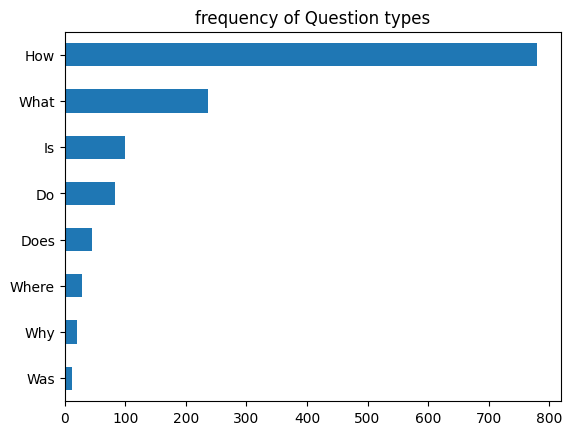

In [ ]:
import matplotlib.pyplot as plt
counts={}
question_types=["What","How",'Is','Does','Do','Was','Where','Why']
for q in question_types:
  counts[q]=dfs['train']['question'].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title('frequency of Question types')
plt.show()

In [ ]:
for question_type in ["How","What","Is"]:
  for question in (dfs['train'][dfs['train'].question.str.startswith(question_type)].sample(n=3,random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


In [ ]:
#Tokenizing text
from transformers import AutoTokenizer
mdl_chkpt='deepset/minilm-uncased-squad2'
tokenizer=AutoTokenizer.from_pretrained(mdl_chkpt)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [ ]:
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,  1029,   102,  2019,
         23378,  2003,  2055,  1015, 16914,  1013,  3371,  1010,  2061,  2055,
         25961,  2847,  5834,  2006,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

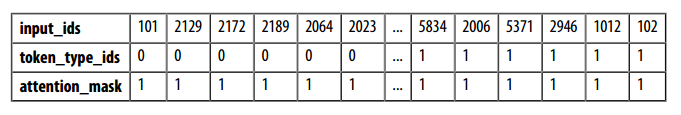

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

model=AutoModelForQuestionAnswering.from_pretrained(mdl_chkpt)
with torch.no_grad():
  outputs=model(**inputs)
print(outputs)

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)


In [ ]:
start_logits=outputs.start_logits
end_logits=outputs.end_logits

In [ ]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


In [ ]:
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: How much music can this hold?
Answer: 6000 hours


In [ ]:
from transformers import pipeline
pipe=pipeline('question-answering',model=model,tokenizer=tokenizer)
pipe(question=question,context=context,topk=3)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:326: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651607394218445, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.2208300530910492,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253580659627914,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [ ]:
pipe(question='why is there no data?',context=context,handle_impossible=True)

{'score': 0.0002626475179567933,
 'start': 16,
 'end': 71,
 'answer': '1 MB/minute, so about 6000 hours depending on file size'}

In [ ]:
#pickle save and load
import pickle
with open('data.pkl', 'wb') as file:
    # Pickle the data and write it to the file
    pickle.dump(model, file)

In [ ]:
with open('data.pkl', 'rb') as file:
    # Load the pickled data from the file
    loaded_data = pickle.load(file)

# Print the loaded data
print(loaded_data)

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elem

In [ ]:
test_con=dfs['test']['context'].iloc[3]
test_quest=dfs['test']['question'].iloc[3]
test_quest_answer=dfs['test']['answers.text'].iloc[3]

In [ ]:
test_con

'I bought this lens for my Canon 20D digital camera and have found it to be a great all-purpose, everyday-use lens.  Here are the best features from my perspective:1.  The range of telephoto zoom is adequate for 90% of photo opportunites.  28-135 mm telephoto in digital photography translates into 48-230 mm in SLR film photography.  Since a standard camera lens is 50-55 mm, the starting range of this zoom lens equals that and then has the added versatility of zooming up to 135 mm (or 230mm in old style camera figures).  In my opinion, this added range of framing a shot gives the photographer so much more creativity, as well as being able to bring objects into closer, more intimate range.  I mentioned that this lens is good for 90% of all general camera shots; the missing 10% are those pictures that require a better zoom (more telephoto zoom), and those pics that need a wider field of view.  You may find that for group photos in close proximity, you want to take a step backwards to get 

In [ ]:
test_quest_answer

array(['I do recommend this lens'], dtype=object)

In [ ]:
#two ways to predict

#First way
#first prepare input/ tokenize and do step by step
test_inputs = tokenizer(test_quest, test_con, return_tensors="pt")
with torch.no_grad():
  outputs1=model(**inputs)
print(outputs1)

start_logits1=outputs1.start_logits
end_logits1=outputs1.end_logits
start_idx1 = torch.argmax(start_logits1)
end_idx1 = torch.argmax(end_logits1) + 1
answer_span1 = test_inputs["input_ids"][0][start_idx1:end_idx1]
answer = tokenizer.decode(answer_span1)
print(f"Question: {test_quest}")
print(f"Answer: {test_con}")

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750, -5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3108, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623, -5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None, attentions=None)
Question: How do you like the lens?
Answer: I bought this lens for my Canon 20D digital camera and have found it to be a great all-purpose, everyday-use lens.  Here are the best features from my perspective:1.  The range of telephoto zoom is adequate for 90% of photo opportunites.  28-135 mm telephoto in digital pho